# Solving a real problem with a LSTM Network

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow import keras
import tensorflow_datasets as tfds
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print('GPU', tf.test.gpu_device_name(), 'configured')

GPU /device:GPU:0 configured


Load the dataset

In [2]:
df = pd.read_csv('data/monthly_milk_production.csv',index_col='Date',parse_dates=True)
df.index.freq='MS'

In [3]:
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator

train = df.iloc[:156]
test = df.iloc[156:]
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

Define the generator to use 12 months

In [7]:
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [10]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [12]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
144/144 [==============================] - 3s 10ms/step - loss: 0.0539
Epoch 2/50
144/144 [==============================] - 2s 12ms/step - loss: 0.0214
Epoch 3/50
144/144 [==============================] - 2s 12ms/step - loss: 0.0170
Epoch 4/50
144/144 [==============================] - 2s 12ms/step - loss: 0.0125
Epoch 5/50
144/144 [==============================] - 2s 12ms/step - loss: 0.0078
Epoch 6/50
144/144 [==============================] - 2s 12ms/step - loss: 0.0085
Epoch 7/50
144/144 [==============================] - 2s 12ms/step - loss: 0.0041
Epoch 8/50
144/144 [==============================] - 2s 12ms/step - loss: 0.0041
Epoch 9/50
144/144 [==============================] - 2s 12ms/step - loss: 0.0037
Epoch 10/50
144/144 [==============================] - 2s 12ms/step - loss: 0.0038
Epoch 11/50
144/144 [==============================] - 2s 12ms/step - loss: 0.0044
Epoch 12/50
144/144 [==============================] - 2s 12ms/step - loss: 0.0035
Epoch 13/50
1

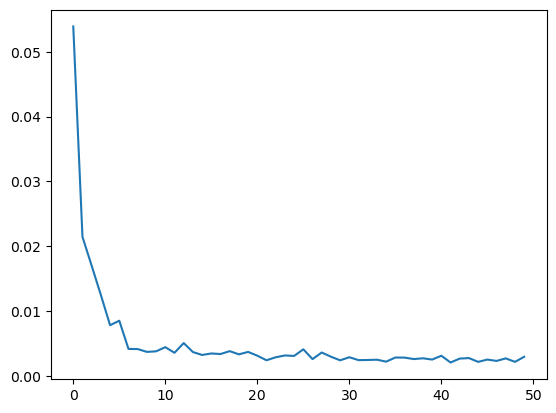

In [13]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Lets predict the whole test set

In [14]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch, verbose=False)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

27.26681038930439


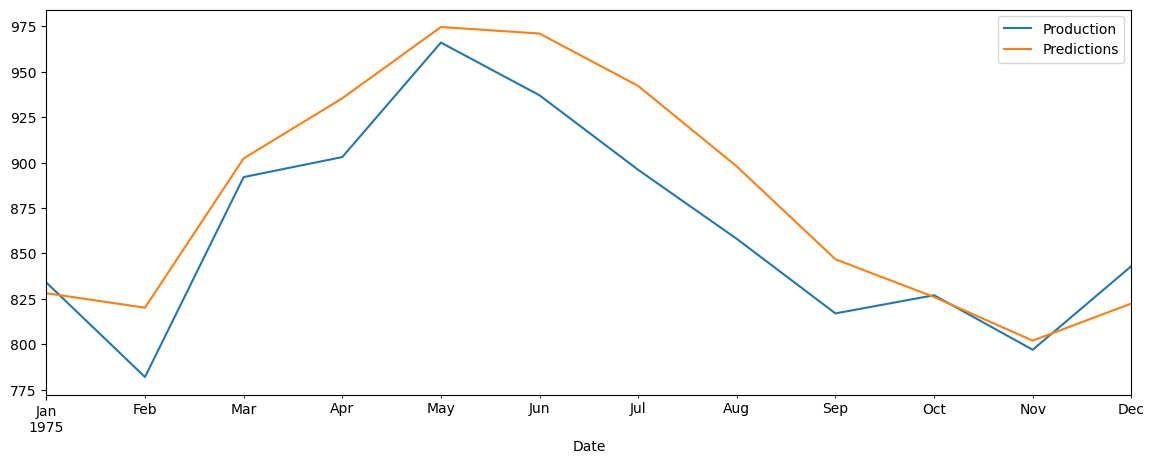

In [15]:
from sklearn.metrics import mean_squared_error
from math import sqrt

true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions
test.plot(figsize=(14,5))

rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
print(rmse)

## Influence on the number of previous values to use

In [16]:
def test_number_of_inputs(n_input, epochs=50):
    generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

    # define model
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    # fit model
    model.fit(generator,epochs=epochs, verbose=False)

    test_predictions = []

    first_eval_batch = scaled_train[-n_input:]
    current_batch = first_eval_batch.reshape((1, n_input, n_features))

    for i in range(len(test)):

        # get the prediction value for the first batch
        current_pred = model.predict(current_batch, verbose=False)[0]

        # append the prediction into the array
        test_predictions.append(current_pred) 

        # use the prediction to update the batch and remove the first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

    true_predictions = scaler.inverse_transform(test_predictions)
    test['Predictions'] = true_predictions

    from sklearn.metrics import mean_squared_error
    from math import sqrt
    rmse=sqrt(mean_squared_error(test['Production'],test['Predictions']))
    test.plot(figsize=(14,5))
    print(rmse)

33.85041183411239


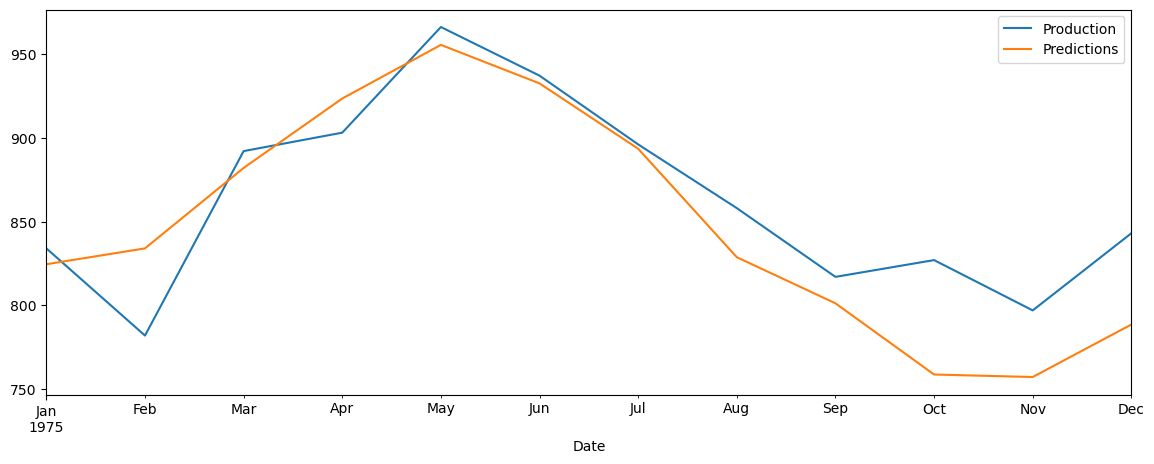

In [17]:
test_number_of_inputs(8)

56.924698346891724


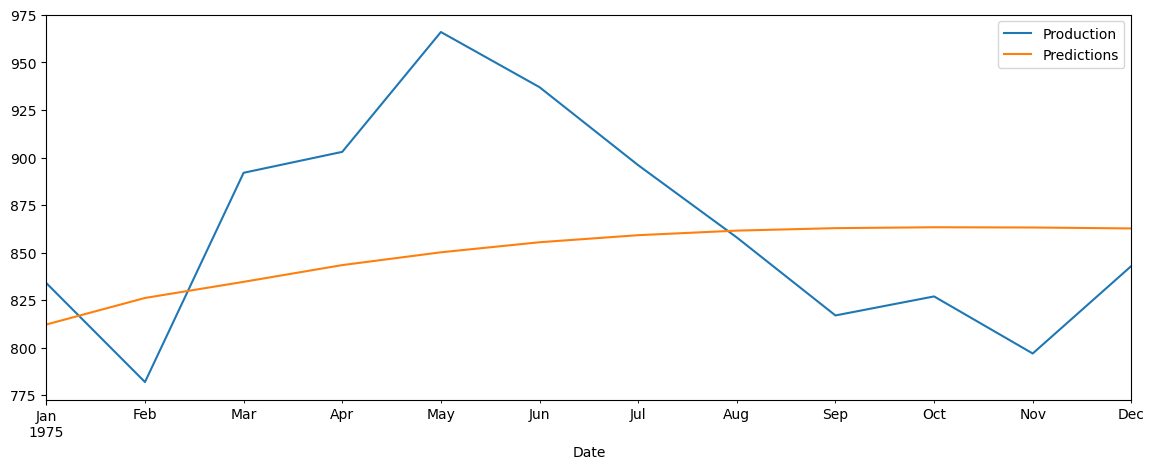

In [18]:
test_number_of_inputs(4)

155.0714015488772


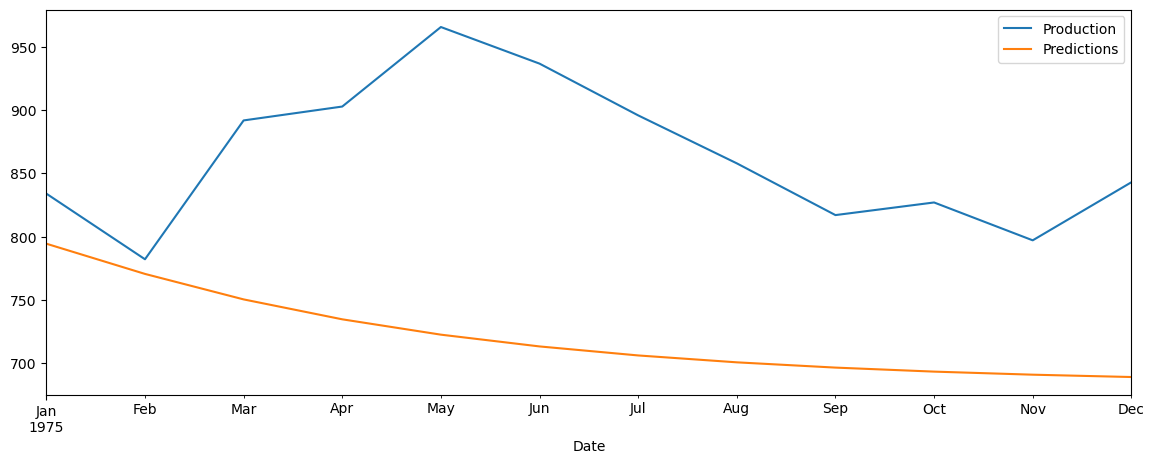

In [19]:
test_number_of_inputs(2)

## Now, lets increment the forecasting horizon

In [20]:
train = df.iloc[:100]
test = df.iloc[100:]

In [21]:
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

68.26552922072388


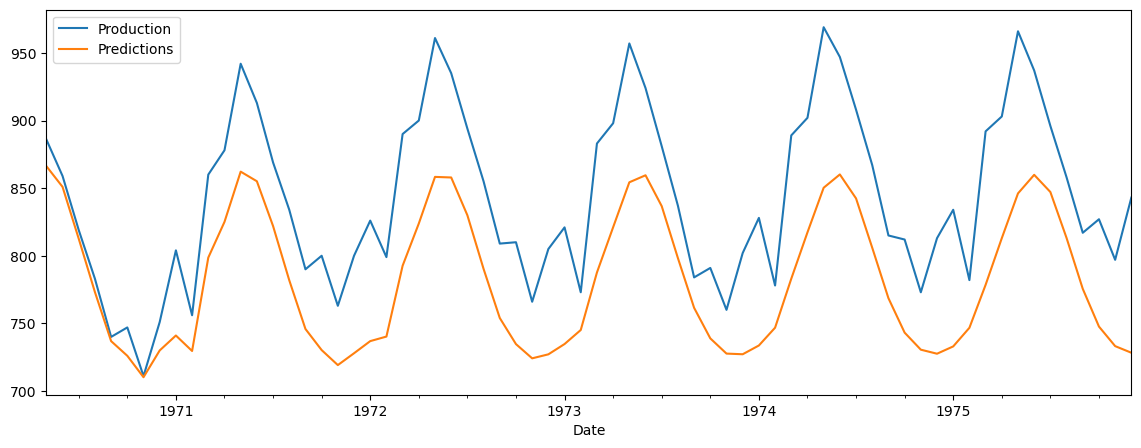

In [22]:
test_number_of_inputs(12, 50)